2024-06-19 03:30:16,247 - INFO - npy 파일 로드 완료: 총 20000개의 이미지


진행 상황: 100.00% (20000/20000), 경과 시간: 147.94초


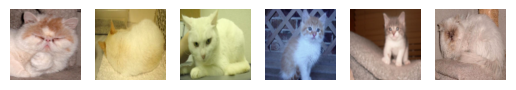

2024-06-19 03:32:45,656 - INFO - 총 6개의 사람이미지가 분류되었고, 19994개의 이미지가 남았습니다.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logging
import sys
import time
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.lite.python.interpreter import Interpreter

# 로그 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 모델 및 데이터 파일 경로
model_path = r"C:\github\Data\HCB_model\model_unquant.tflite"
npy_file_path = r"C:\github\Data\final_files\p2data.npy"

# TensorFlow Lite 모델 로드
interpreter = Interpreter(model_path)
interpreter.allocate_tensors()

# 입력 및 출력 텐서 정보 가져오기
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# npy 파일 로드
images = np.load(npy_file_path)
total_images = len(images)
logging.info(f'npy 파일 로드 완료: 총 {total_images}개의 이미지')

# 모델 입력 크기 가져오기
input_shape = input_details[0]['shape'][1:4]

# 이미지 분류 및 사람 이미지 저장
person_images = []
remaining_images = []
start_time = time.time()

for i, image in enumerate(images):
    # 이미지 리사이즈
    img = array_to_img(image)
    img = img.resize(input_shape[:2])
    image = img_to_array(img)
    image = np.expand_dims(image, axis=0)  # 모델 입력에 맞게 차원 확장

    # TensorFlow Lite 모델로 예측
    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(prediction, axis=1)

    if predicted_class == 0:  # 사람 클래스로 예측되면 (0은 예시로 사용, 실제 클래스 인덱스 확인 필요)
        person_images.append(image[0])
    else:
        remaining_images.append(image[0])
    
    # 진행 상황 표시
    percent_complete = (i + 1) / total_images * 100
    elapsed_time = time.time() - start_time
    print(f'\r진행 상황: {percent_complete:.2f}% ({i + 1}/{total_images}), 경과 시간: {elapsed_time:.2f}초', end='')
    sys.stdout.flush()

print()  # 진행 상황 표시를 완료한 후 줄 바꿈

# 사람 이미지 plot
if person_images:
    for i, person_image in enumerate(person_images):
        plt.subplot(1, len(person_images), i + 1)
        plt.imshow(array_to_img(person_image))
        plt.axis('off')
    plt.show()
else:
    logging.info('사람으로 분류된 이미지가 없습니다.')

logging.info(f'총 {len(person_images)}개의 사람이미지가 분류되었고, {len(remaining_images)}개의 이미지가 남았습니다.')


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logging
import sys
import time
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.lite.python.interpreter import Interpreter
from sklearn.utils import shuffle

# 로그 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 모델 및 데이터 파일 경로
model_path = r"C:\github\Data\HCB_model\model_unquant.tflite"
npy_file_path = r"C:\github\Data\final_files\p2data.npy"

# TensorFlow Lite 모델 로드
interpreter = Interpreter(model_path)
interpreter.allocate_tensors()

# 입력 및 출력 텐서 정보 가져오기
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# npy 파일 로드
images = np.load(npy_file_path)
total_images = len(images)
logging.info(f'npy 파일 로드 완료: 총 {total_images}개의 이미지')

# 이미지 섞기
yourid = 20224531
images = shuffle(images, random_state=yourid)

# 모델 입력 크기 가져오기
input_shape = input_details[0]['shape'][1:4]

# 이미지 분류 및 사람 이미지 저장
person_images = []
probabilities = []
start_time = time.time()

for i, image in enumerate(images):
    # 이미지 리사이즈
    img = array_to_img(image)
    img = img.resize(input_shape[:2])
    image = img_to_array(img) / 255.0  # 픽셀 값을 [0, 1] 사이로 스케일링
    image = np.expand_dims(image, axis=0)  # 모델 입력에 맞게 차원 확장

    # TensorFlow Lite 모델로 예측
    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_details[0]['index'])[0]

    human_prob = prediction[0]  # 사람일 확률
    cat_prob = prediction[1]    # 고양이일 확률
    dog_prob = prediction[2]    # 개일 확률

    predicted_class = np.argmax(prediction)

    print(f"이미지 {i} - 사람: {human_prob:.2f}, 고양이: {cat_prob:.2f}, 개: {dog_prob:.2f}")

    if predicted_class == 0:  # 사람이 일 확률이 가장 높은 경우
        person_images.append(image[0])
        probabilities.append(human_prob)
    
    # 진행 상황 표시
    percent_complete = (i + 1) / total_images * 100
    elapsed_time = time.time() - start_time
    print(f'\r진행 상황: {percent_complete:.2f}% ({i + 1}/{total_images}), 경과 시간: {elapsed_time:.2f}초', end='')
    sys.stdout.flush()

print()  # 진행 상황 표시를 완료한 후 줄 바꿈

# 사람이 일 확률이 가장 높은 100개의 이미지 플롯
if person_images:
    sorted_indices = np.argsort(probabilities)[::-1]  # 확률 내림차순으로 정렬
    top_indices = sorted_indices[:100]  # 상위 100개 인덱스

    plt.figure(figsize=(10, 10))
    for j, idx in enumerate(top_indices):
        plt.subplot(10, 10, j + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(array_to_img(person_images[idx]))
    plt.show()
else:
    logging.info('사람으로 분류된 이미지가 없습니다.')

logging.info(f'총 {len(person_images)}개의 사람이미지가 분류되었습니다.')


2024-06-19 03:43:19,475 - INFO - npy 파일 로드 완료: 총 20000개의 이미지


2024-06-19 03:47:55,012 - INFO - npy 파일 로드 완료: 총 20000개의 이미지


진행 상황: 100.00% (20000/20000), 경과 시간: 63.78초


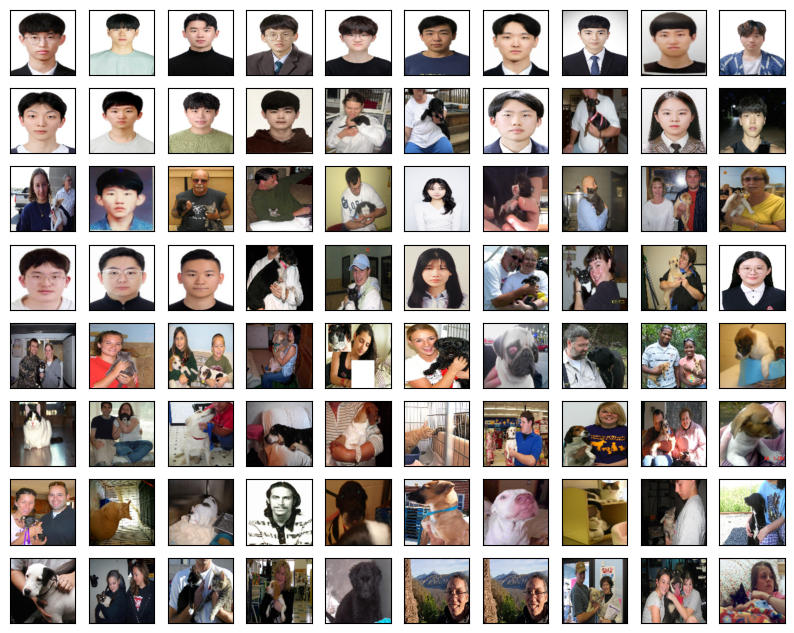

2024-06-19 03:49:01,898 - INFO - 총 80개의 사람이미지가 분류되었습니다.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logging
import sys
import time
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.lite.python.interpreter import Interpreter
from sklearn.utils import shuffle

# 로그 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 모델 및 데이터 파일 경로
model_path = r"C:\github\Data\HCB_model\model_unquant.tflite"
npy_file_path = r"C:\github\Data\final_files\p2data.npy"

# TensorFlow Lite 모델 로드
interpreter = Interpreter(model_path)
interpreter.allocate_tensors()

# 입력 및 출력 텐서 정보 가져오기
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# npy 파일 로드
images = np.load(npy_file_path)
total_images = len(images)
logging.info(f'npy 파일 로드 완료: 총 {total_images}개의 이미지')

# 이미지 섞기
yourid = 20224531
images = shuffle(images, random_state=yourid)

# 모델 입력 크기 가져오기
input_shape = input_details[0]['shape'][1:4]

# 이미지 분류 및 사람 이미지 저장
person_images = []
probabilities = []
start_time = time.time()

for i, image in enumerate(images):
    # 이미지 리사이즈
    img = array_to_img(image)
    img = img.resize(input_shape[:2])
    image = img_to_array(img) / 255.0  # 픽셀 값을 [0, 1] 사이로 스케일링
    image = np.expand_dims(image, axis=0)  # 모델 입력에 맞게 차원 확장

    # TensorFlow Lite 모델로 예측
    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_details[0]['index'])[0]

    predicted_class = np.argmax(prediction)

    if predicted_class == 0:  # 사람이 일 확률이 가장 높은 경우
        person_images.append(image[0])
        probabilities.append(prediction[0])  # 사람일 확률 저장
    
    # 진행 상황 표시
    percent_complete = (i + 1) / total_images * 100
    elapsed_time = time.time() - start_time
    if (i + 1) % 10 == 0:  # 10개마다 업데이트
        print(f'\r진행 상황: {percent_complete:.2f}% ({i + 1}/{total_images}), 경과 시간: {elapsed_time:.2f}초', end='')
        sys.stdout.flush()

print()  # 진행 상황 표시를 완료한 후 줄 바꿈

# 사람이 일 확률이 가장 높은 100개의 이미지 플롯
if person_images:
    sorted_indices = np.argsort(probabilities)[::-1]  # 확률 내림차순으로 정렬
    top_indices = sorted_indices[:100]  # 상위 100개 인덱스

    plt.figure(figsize=(10, 10))
    for j, idx in enumerate(top_indices):
        plt.subplot(10, 10, j + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(array_to_img(person_images[idx]))
    plt.show()
else:
    logging.info('사람으로 분류된 이미지가 없습니다.')

logging.info(f'총 {len(person_images)}개의 사람이미지가 분류되었습니다.')
